# PyTorch semantic segmentation 
For this last exercise you are going to work on a new computer vision task called semantic segmentation where not an entire image but each pixel is classified. This means in comparison to image classification your model outputs not a single class but a segmentation with the same size as the input image. Since you have already learned a lot in the past exercises and you are now familiar with the basics of PyTorch the model design and architecture as well as the training is totally up to you. We only provide you with the train and validation dataset and recommend you to look for PyTorch implementations and finetuning weights of famous semantic segmentation networks.

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from dl4cv.classifiers.segmentation_network import SegmentationNetwork
from dl4cv.data_utils import SegmentationData

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# GPU
gpu_device = 0
torch.cuda.set_device(gpu_device)
print('Chosen GPU device: ' + str(torch.cuda.current_device()))

Chosen GPU device: 0


## Train and validation data

Download the dataset with the `datasets/get_segmentation_dataset.sh` script and make yourself familiar with it. Look at the labels described in `datasets/segmentation_data/info.html` and note the label `unlabeled`. Pixels with the label `unlabeled` should neither be considered in your loss nor the accuracy.

In [2]:
train_data = SegmentationData(root='datasets/segmentation_data',
                              image_list='train.txt')

val_data = SegmentationData(root='datasets/segmentation_data',
                            image_list='val.txt')

Train size: 276
Validation size: 59
Img size: torch.Size([3, 240, 240])
Segmentation size: torch.Size([240, 240])


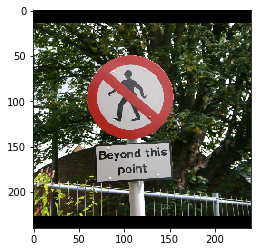

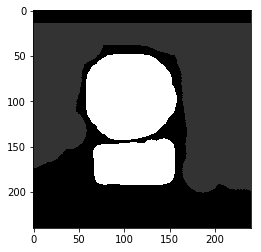

In [3]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))

img, target = train_data[1]
print("Img size: " + str(img.size()))
print("Segmentation size: " + str(target.size()))
plt.figure(figsize=(4,4))
plt.imshow(img.numpy().transpose(1,2,0))
plt.show()
plt.figure(figsize=(4,4))
plt.imshow(target.numpy())
plt.show()

In [5]:
from dl4cv.classifiers.segmentation_network import SegmentationNetwork
m_n = SegmentationNetwork(pretr_net='alexnet', netstride=32)
for name, module in m_n.named_children():
    print (name, module)

(17.0, 17.0, 1, 32)
(-272.0, 240, 17.0, 32)


('features', Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
))
('classifier', Sequential (
  (0): Dropout (p = 0.5)
  (1): Conv2d(256, 4096, kernel_size=(6, 6), stride=(6, 6))
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
  (5): ReLU (inplace)
))
('features_1', Sequential (
  (0): Conv2d(3, 64, k

## Train your network
Implement your network architecture in `classifiers.segmentation_network.py` and adapt your `Solver` to process segmentation labels. Think about finetuning a model instead of training from scratch. If you are not equipped with a CUDA GPU test your model locally and then finish training on the computers in our lab.

In [10]:
from dl4cv.classifiers.segmentation_network import SegmentationNetwork
from dl4cv.classifiers.solver import Solver

############################################################################
#                             YOUR CODE                                    #
############################################################################
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=1)

import torch.nn.functional as F

def CrossEntropy2d():
    def wrap(inputs, targets, weight=None, pixel_average=True):
        n, c, h, w = inputs.size()
        #print('inputsshape',inputs.size())
        #print('targetsshape', targets.size())

        inputs = inputs.transpose(1, 2).transpose(2, 3).contiguous()
        inputs = inputs[targets.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0].view(-1, c)

        targets_mask = targets >= 0
        targets = targets[targets_mask]
        
        #loss = F.nll_loss(F.log_softmax(input), target, weight=weight, size_average=False)
        loss = F.cross_entropy(inputs, targets, weight=weight, size_average=False)
        if pixel_average:
            loss /= targets_mask.data.sum()
        return loss
    return wrap

#model = SegmentationNetwork(pretr_net='alexnet',gpu_device=gpu_device,netstride=32)
#model.init_alexnet_weight()
solver = Solver(optim_args={"lr": 1e-4, "weight_decay": 0.001}, loss_func=CrossEntropy2d)
solver.train_segmentation(model, train_loader, val_loader, log_nth=5, num_epochs=5, gpu_device=gpu_device)

START TRAIN.


[Iteration 5/28] TRAIN loss: 2.5772


[Iteration 10/28] TRAIN loss: 2.2035


[Iteration 15/28] TRAIN loss: 2.4319


[Iteration 20/28] TRAIN loss: 2.4444


[Iteration 25/28] TRAIN loss: 2.3267


[Epoch 1/5] TRAIN acc/loss: 0.2448/2.3314


[Epoch 1/5] VAL acc/loss: 0.2654/3.1067


[Iteration 5/28] TRAIN loss: 2.3511


[Iteration 10/28] TRAIN loss: 2.5168


[Iteration 15/28] TRAIN loss: 2.5631


[Iteration 20/28] TRAIN loss: 2.0921


[Iteration 25/28] TRAIN loss: 2.5012


[Epoch 2/5] TRAIN acc/loss: 0.2528/1.8557


[Epoch 2/5] VAL acc/loss: 0.2738/3.0894


[Iteration 5/28] TRAIN loss: 2.1568


[Iteration 10/28] TRAIN loss: 2.4653


[Iteration 15/28] TRAIN loss: 2.4829


[Iteration 20/28] TRAIN loss: 2.2925


[Iteration 25/28] TRAIN loss: 2.7567


[Epoch 3/5] TRAIN acc/loss: 0.2409/2.1565


[Epoch 3/5] VAL acc/loss: 0.2635/3.1970


[Iteration 5/28] TRAIN loss: 2.5186


[Iteration 10/28] TRAIN loss: 2.2286


[Iteration 15/28] TRAIN loss: 2.3843


[Iteration 20/28] TRAIN loss: 2.3354


[Iteration 25/28] TRAIN loss: 2.0448


[Epoch 4/5] TRAIN acc/loss: 0.2534/2.2817


[Epoch 4/5] VAL acc/loss: 0.2767/3.0941


[Iteration 5/28] TRAIN loss: 1.8872


[Iteration 10/28] TRAIN loss: 1.9555


[Iteration 15/28] TRAIN loss: 2.0674


[Iteration 20/28] TRAIN loss: 2.2683


[Iteration 25/28] TRAIN loss: 2.3119


[Epoch 5/5] TRAIN acc/loss: 0.2663/2.4639


# Test your model
Since this dataset is very small we only provided you with a validation set.

In [25]:
test_data = SegmentationData(root='datasets/segmentation_data', image_list='val.txt')
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)
#model = SegmentationNetwork(pretr_net='alexnet',gpu_device=gpu_device)

test_scores = []
model.eval()
scores = 0
count = 0
for batch in test_loader:
    inputs, labels = Variable(batch[0].cuda(gpu_device), requires_grad=False), Variable(batch[1].cuda(gpu_device), requires_grad=False)

    outputs = model.forward(inputs)
    #_, preds = torch.max(outputs, 1)
    #labels_mask = labels >= 0
    #test_scores.append(np.mean((preds == labels)[labels_mask].data.numpy()))
    
    y_pred = np.argmax(outputs.data.cpu().numpy(), axis=1)
    # print(y_pred)
    y_actual = labels.data.cpu().numpy()
    y_actual_mask = np.where(y_actual >= 0)
    #print (y_actual_mask)
    pred_acc = np.mean((np.array(y_pred) == np.array(y_actual))[y_actual_mask])
    test_scores.append(pred_acc)
    #print (len(y_actual_mask))
    #print ('y_mask',np.array(y_actual_mask).shape)
    #count+=np.array(y_actual_mask).shape[1]
    
    
model.train()
test_acc = np.mean(test_scores)
print(test_acc)

0.519605777009


# Visualization

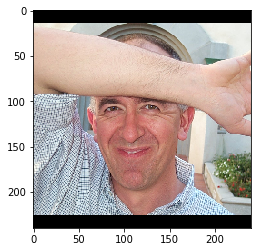

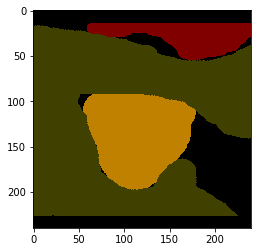

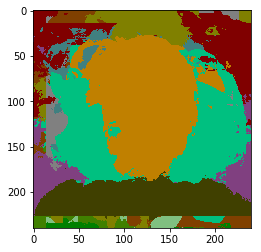

In [26]:
from dl4cv.data_utils import label_img_to_rgb

img, target, pred = inputs.data.cpu().numpy()[0], labels.data.cpu().numpy()[0], y_pred[0]
              
plt.figure(figsize=(4,4))
plt.imshow(img.transpose(1,2,0))
plt.show()
plt.figure(figsize=(4,4))
plt.imshow(label_img_to_rgb(target))
plt.show()
plt.figure(figsize=(4,4))
plt.imshow(label_img_to_rgb(pred))
plt.show()

## Save the model

When you are satisfied with your training, save the model for submission.

In [12]:
model.save("models/segmentation_network_16Stride.model")

Saving model... models/segmentation_network_16Stride.model


## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:
    $$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.5 \\
        \left(\frac{50}{\exp(0.5 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.5 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

In [ ]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.5, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()